In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init

n_labels = 10
cuda = torch.cuda.is_available()
device = "cuda:0" if cuda else "cpu"

def onehot(k):
    """
    Converts a number to its one-hot or 1-of-k representation
    vector.
    :param k: (int) length of vector
    :return: onehot function
    """
    def encode(label):
        y = torch.zeros(k)
        if label < k:
            y[label] = 1
        return y
    return encode

def get_mnist(location="./", batch_size=64, labels_per_class=100):
    from functools import reduce
    from operator import __or__
    from torch.utils.data.sampler import SubsetRandomSampler
    from torchvision.datasets import MNIST
    import torchvision.transforms as transforms

    flatten_bernoulli = lambda x: transforms.ToTensor()(x).view(-1).bernoulli()

    mnist_train = MNIST(location, train=True, download=True,
                        transform=flatten_bernoulli, target_transform=onehot(n_labels))
    mnist_valid = MNIST(location, train=False, download=True,
                        transform=flatten_bernoulli, target_transform=onehot(n_labels))

    def get_sampler(labels, n=None):
        # Only choose digits in n_labels
        (indices,) = np.where(reduce(__or__, [labels == i for i in np.arange(n_labels)]))

        # Ensure uniform distribution of labels
        np.random.shuffle(indices)
        indices = np.hstack([list(filter(lambda idx: labels[idx] == i, indices))[:n] for i in range(n_labels)])

        indices = torch.from_numpy(indices)
        sampler = SubsetRandomSampler(indices)
        return sampler

    # Dataloaders for MNIST
    labelled = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, num_workers=2, pin_memory=cuda,
                                           sampler=get_sampler(mnist_train.train_labels.numpy(), labels_per_class))
    unlabelled = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, num_workers=2, pin_memory=cuda,
                                             sampler=get_sampler(mnist_train.train_labels.numpy()))
    validation = torch.utils.data.DataLoader(mnist_valid, batch_size=batch_size, num_workers=2, pin_memory=cuda,
                                             sampler=get_sampler(mnist_valid.test_labels.numpy()))

    return labelled, unlabelled, validation

class Perceptron(nn.Module):
    def __init__(self, dims, activation_fn=F.relu, output_activation=None):
        super(Perceptron, self).__init__()
        self.dims = dims
        self.activation_fn = activation_fn
        self.output_activation = output_activation

        self.layers = nn.ModuleList(list(map(lambda d: nn.Linear(*d), list(zip(dims, dims[1:])))))

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i == len(self.layers)-1 and self.output_activation is not None:
                x = self.output_activation(x)
            else:
                x = self.activation_fn(x)

        return x
    
class Stochastic(nn.Module):
    """
    Base stochastic layer that uses the
    reparametrization trick [Kingma 2013]
    to draw a sample from a distribution
    parametrised by mu and log_var.
    """
    def reparametrize(self, mu, log_var):
        epsilon = Variable(torch.randn(mu.size()), requires_grad=False)

        if mu.is_cuda:
            epsilon = epsilon.cuda()

        # log_std = 0.5 * log_var
        # std = exp(log_std)
        std = log_var.mul(0.5).exp_()

        # z = std * epsilon + mu
        z = mu.addcmul(std, epsilon)

        return z


class GumbelSoftmax(Stochastic):
    """
    Layer that represents a sample from a categorical
    distribution. Enables sampling and stochastic
    backpropagation using the Gumbel-Softmax trick.
    """
    def __init__(self, in_features, out_features, n_distributions):
        super(GumbelSoftmax, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.n_distributions = n_distributions

        self.logits = nn.Linear(in_features, n_distributions*out_features)

    def forward(self, x, tau=1.0):
        logits = self.logits(x).view(-1, self.n_distributions)

        # variational distribution over categories
        softmax = F.softmax(logits, dim=-1) #q_y
        sample = self.reparametrize(logits, tau).view(-1, self.n_distributions, self.out_features)
        sample = torch.mean(sample, dim=1)

        return sample, softmax

    def reparametrize(self, logits, tau=1.0):
        epsilon = Variable(torch.rand(logits.size()), requires_grad=False).to(device)

        # Gumbel distributed noise
        gumbel = -torch.log(-torch.log(epsilon+1e-8)+1e-8)
        # Softmax as a continuous approximation of argmax
        y = F.softmax((logits + gumbel)/tau, dim=1)
        return y
    
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


class UnFlatten(nn.Module):
    def __init__(self, size, dim=-1):
        super().__init__()
        self.dim = dim
        self.size = size
    def forward(self, input):
        return input.view(input.size(0), self.dim, self.size, self.size)


class GumbelAutoencoder(nn.Module):
    def __init__(self, dims, n_samples=100):
        super(GumbelAutoencoder, self).__init__()

        [x_dim, z_dim, h_dim] = dims
        self.z_dim = z_dim
        self.n_samples = n_samples

        #self.encoder = Perceptron([x_dim, *h_dim])
        self.encoder = nn.Sequential(
            UnFlatten(size=28),
            nn.Conv2d(1, 16, kernel_size=4, stride=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=2, stride=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=2, stride=1),
            nn.ReLU(),
            #nn.Conv2d(128, 256, kernel_size=4, stride=2),
            #nn.ReLU(),
            Flatten(),
            nn.Linear(16928, h_dim[-1])
        )
        self.sampler = GumbelSoftmax(h_dim[-1], z_dim, n_samples)
        #self.decoder = Perceptron([z_dim, *reversed(h_dim), x_dim], output_activation=torch.sigmoid)
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 16928),
            UnFlatten(dim=32, size=23),
            nn.ConvTranspose2d(32, 32, kernel_size=2, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=4, stride=1),
            #nn.ReLU(),
            #nn.ConvTranspose2d(32, 1, kernel_size=6, stride=2),
            nn.Sigmoid(),
            Flatten()
        )

        self.kl_divergence = 0

        for m in self.modules():
            if isinstance(m, nn.Linear):
                init.xavier_normal_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()

    def _kld(self, qz):
        k = Variable(torch.FloatTensor([self.z_dim]), requires_grad=False).to(device)
        kl = qz * (torch.log(qz + 1e-8) - torch.log(1.0/k))
        kl = kl.view(-1, self.n_samples, self.z_dim)
        return torch.sum(torch.sum(kl, dim=1), dim=1)

    def forward(self, x, y=None, tau=1):
        x = self.encoder(x)

        sample, qz = self.sampler(x, tau)
        self.kl_divergence = self._kld(qz)

        x_mu = self.decoder(sample)

        return x_mu

    def sample(self, z):
        return self.decoder(z)

In [2]:
# Latent space dimension should be equal to the number of classes=10
model = GumbelAutoencoder([784, 10, [256, 128]], n_samples=5).to(device)
model

GumbelAutoencoder(
  (encoder): Sequential(
    (0): UnFlatten()
    (1): Conv2d(1, 16, kernel_size=(4, 4), stride=(1, 1))
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
    (4): ReLU()
    (5): Conv2d(32, 32, kernel_size=(2, 2), stride=(1, 1))
    (6): ReLU()
    (7): Flatten()
    (8): Linear(in_features=16928, out_features=128, bias=True)
  )
  (sampler): GumbelSoftmax(
    (logits): Linear(in_features=128, out_features=50, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=16928, bias=True)
    (1): UnFlatten()
    (2): ConvTranspose2d(32, 32, kernel_size=(2, 2), stride=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(16, 1, kernel_size=(4, 4), stride=(1, 1))
    (7): Sigmoid()
    (8): Flatten()
  )
)

In [3]:
_, train, validation = get_mnist(location="./", batch_size=64)

# We use this custom BCE function until PyTorch implements reduce=False
def binary_cross_entropy(r, x):
    return -torch.sum(x * torch.log(r + 1e-8) + (1 - x) * torch.log(1 - r + 1e-8), dim=-1)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, betas=(0.9, 0.999))

In [4]:
from torch.autograd import Variable

# Temperature
tau = Variable(torch.FloatTensor([4]), requires_grad=False).to(device)

for epoch in range(25):
    model.train()
    total_loss = 0
    for (u, _) in train:
        u = Variable(u)

        if cuda: u = u.cuda(device=0)

        reconstruction = model(u, tau=tau)
        
        likelihood = -binary_cross_entropy(reconstruction, u)
        elbo = likelihood - model.kl_divergence
        
        L = -torch.mean(elbo)

        L.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += L.data.item()
        
    m = len(train)
        
    #if epoch % 5 == 0:
    print(f"Epoch: {epoch}\tL: {total_loss/m:.2f}\tTau: {tau.item()}")

    # Anneal temperature variable
    
    tau *= 0.9
    
    

Epoch: 0	L: 219.20	Tau: 4.0
Epoch: 1	L: 142.33	Tau: 3.5999999046325684
Epoch: 2	L: 136.82	Tau: 3.239999771118164
Epoch: 3	L: 134.23	Tau: 2.9159996509552
Epoch: 4	L: 132.40	Tau: 2.6243996620178223
Epoch: 5	L: 131.13	Tau: 2.36195969581604
Epoch: 6	L: 130.58	Tau: 2.1257636547088623
Epoch: 7	L: 130.51	Tau: 1.9131872653961182
Epoch: 8	L: 130.68	Tau: 1.7218685150146484
Epoch: 9	L: 131.02	Tau: 1.5496816635131836
Epoch: 10	L: 131.50	Tau: 1.3947134017944336
Epoch: 11	L: 131.81	Tau: 1.2552419900894165
Epoch: 12	L: 132.47	Tau: 1.1297177076339722
Epoch: 13	L: 132.86	Tau: 1.016745924949646
Epoch: 14	L: 133.41	Tau: 0.9150713086128235
Epoch: 15	L: 133.87	Tau: 0.8235641717910767
Epoch: 16	L: 134.21	Tau: 0.7412077188491821
Epoch: 17	L: 134.73	Tau: 0.6670869588851929
Epoch: 18	L: 134.99	Tau: 0.6003782749176025
Epoch: 19	L: 135.40	Tau: 0.5403404235839844
Epoch: 20	L: 135.53	Tau: 0.486306369304657
Epoch: 21	L: 135.80	Tau: 0.43767571449279785
Epoch: 22	L: 136.12	Tau: 0.39390814304351807
Epoch: 23	L: 136.30

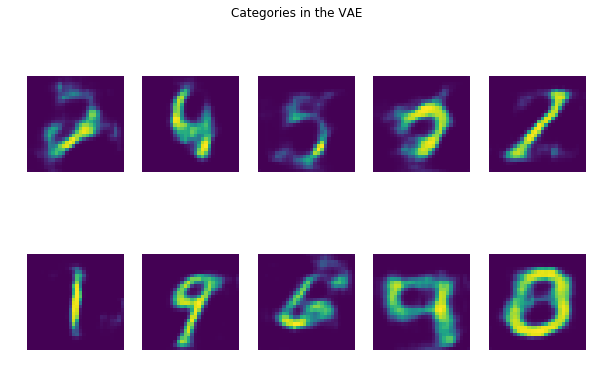

In [7]:
import matplotlib.pyplot as plt
f, axarr = plt.subplots(2, 5, figsize=(10, 6))

x = torch.zeros(10, 10).to(device)
for i in range(10):
    x[i, i]= 1

reconstruction = model.decoder(x)
r = reconstruction.data.cpu().numpy()

for i, ax in enumerate(axarr.flat):
    ax.imshow(r[i].reshape(28, 28), cmap="viridis")
    ax.axis("off")
    
plt.suptitle("Categories in the VAE")
plt.show()

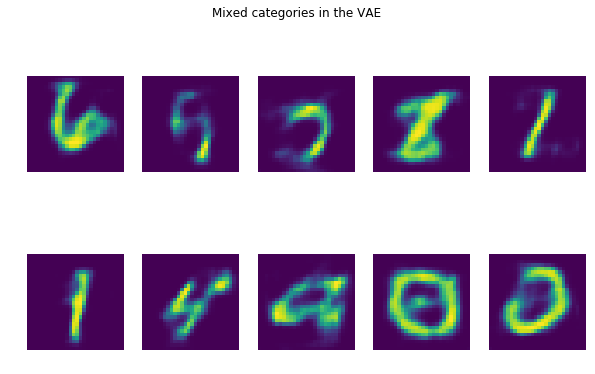

In [6]:
import matplotlib.pyplot as plt
f, axarr = plt.subplots(2, 5, figsize=(10, 6))

x = torch.zeros(10, 10).to(device)
for i in range(10):
    x[i, i]= 0.5
    x[i, (i+1) % 10] = 0.5

reconstruction = model.decoder(x)
r = reconstruction.data.cpu().numpy()

for i, ax in enumerate(axarr.flat):
    ax.imshow(r[i].reshape(28, 28), cmap="viridis")
    ax.axis("off")
    
plt.suptitle("Mixed categories in the VAE")
plt.show()